# 17.07 Feature Engineering 1: From Variables to Features

After your data has been cleaned and explored, the next step is to determine features that you think will be useful in explaining the target variable.  This step is called **feature engineering**.  In this notebook you will approach feature engineering and what kind of techniques you can use.  In this step of the EDA process, you need to transform your variables into **features**.  Variables become _features_ when they are well-suited to work within your model to explain the target variable.  

Feature engineering will be analyzed in three steps: 
1. Transforming existing variables 
2. Creating new variables 
3. Selecting the features 
The 1<sup>st</sup> & 2<sup>nd</sup> steps will be covered in this notebook and the 3<sup>rd</sup> will be covered in the next notebook, 17.08 Feature Engineering 2: Dimensionality and PCA.

### Transforming the Existing Variables 

Transforming the existing variables is a very common need for numerous reasons.
1. Machine learning models can only work with numeric variables, categorical variables that have text values need to be converted to numeric values.
2. Some machine learning models assume that target variables are normally distributed.  In order to use these models, you may need to transform the target to be normally distributed.
3. Some machine learning models are very sensitive to the relative magnitude of values.  So, you may need to limit the values of the variables to some fixed range.  Usually, you do this by normalizing the values. 
4. To help your intuition and understanding of the data, you may want to transform variables to a different unit of measurement. 
Each of these will be covered, in order, below.

### Working with Categorical Variables 

Most models require that all data be numeric.  You need to convert string based categorical data in order to use it.  On method for this purpose is called **one hot encoding**.  In one hot encoding, the information from a categorical variable with X levels, you create X-1 numeric features, each of which is coded 1 or 0.  The resulting variables that take 0 or 1 for each category are know as **dummy** or **indicator** variables.  To apply one hot encoding to a categorical variable, you can use the Pandas `get_dummmies()` function.

Consider the YouTube dataset.  The variable _Grade_ is categorical, taking the values `A++`, `A+`, `A`, `A-`, and `B+`.  While the _Grade_ variable has five levels only four features are needed to represent all of the information.  Why four? The reason being if you know the values for `A++`, `A+`, `A`, and `A-` are 0, then you also know the value for `B+` must be 1.  This level without a feature is called the _reference_ value.  Illustrate this with the YouTube dataset:


In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import pandas as pd 
import scipy.stats as stats 

from scipy.stats.mstats import winsorize
from scipy.stats import jarque_bera # New in this Thinkful module
from scipy.stats import normaltest # New in this Thinkful module
from scipy.stats import boxcox # New in this Thinkful module
from scipy.stats import skew
from sklearn.preprocessing import normalize # New in this Thinkful module
from sklearn.preprocessing import scale # New in this Thinkful module
from sqlalchemy import create_engine 
from sqlalchemy.engine.url import URL 

import warnings 

warnings.filterwarnings("ignore")
plt.style.use("default")
sns.set(style="whitegrid")

In [2]:
kagle = dict(
    drivername="postgresql", 
    username="dsbc_student", 
    password="7*.8G9QH21", 
    host="142.93.121.174", 
    port="5432", 
    database="youtube"
)

engine = create_engine(URL(**kagle), echo=True)

youtube_df = pd.read_sql_query("SELECT * FROM youtube", con=engine)

engine.dispose()

2020-01-02 07:39:59,556 INFO sqlalchemy.engine.base.Engine select version()
2020-01-02 07:39:59,563 INFO sqlalchemy.engine.base.Engine {}
2020-01-02 07:39:59,663 INFO sqlalchemy.engine.base.Engine select current_schema()
2020-01-02 07:39:59,664 INFO sqlalchemy.engine.base.Engine {}
2020-01-02 07:39:59,760 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-01-02 07:39:59,763 INFO sqlalchemy.engine.base.Engine {}
2020-01-02 07:39:59,814 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-01-02 07:39:59,816 INFO sqlalchemy.engine.base.Engine {}
2020-01-02 07:39:59,871 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2020-01-02 07:39:59,872 INFO sqlalchemy.engine.base.Engine {}
2020-01-02 07:39:59,983 INFO sqlalchemy.engine.base.Engine SELECT * FROM youtube
2020-01-02 07:39:59,984 INFO sqlalchemy.engine.base.Engine {}


In [3]:
# Deal with the missing values
youtube_df["Video Uploads"] = youtube_df["Video Uploads"].apply(str.strip).replace("--", np.nan)
youtube_df["Video Uploads"] = pd.to_numeric(youtube_df["Video Uploads"], downcast="float")

youtube_df["Subscribers"] = youtube_df["Subscribers"].apply(str.strip).replace("--", np.nan)
youtube_df["Subscribers"] = pd.to_numeric(youtube_df["Subscribers"], downcast="float")

youtube_df["Grade"] = youtube_df["Grade"].apply(str.strip).replace("",np.nan)

youtube_df["Video Uploads"].fillna(youtube_df["Video Uploads"].mean(), inplace=True)
youtube_df["Subscribers"].fillna(youtube_df["Subscribers"].mean(), inplace=True)

In [4]:
"""
    Apply a one-way winsorization to the highest end of the value distribution.  There are a lot of extreme values, so set the value of the outliers to the values of the 90th percentile.
"""
youtube_df["winsorized_uploads"] = winsorize(youtube_df["Video Uploads"], (0, 0.10))
youtube_df["winsorized_subscribers"] = winsorize(youtube_df["Subscribers"], (0, 0.10))
youtube_df["winsorized_views"] = winsorize(youtube_df["Video views"], (0, 0.10))

for i in range(0,len(youtube_df["Grade"])):
    if pd.isnull(youtube_df["Grade"][i]):
        youtube_df["Grade"][i] = youtube_df["Grade"][i-1]

In [5]:
"""
    Since most models require that all data be numeric, you need to convert string based categorical data to use it.  One method is called 'one hot-encoding'.  In one hot-encoding', to get the information from a categorical variable with X levels, create X-1 numeric features, each of which is coded 1 or 0.  The resulting variables are known as dummy or indicator varialbes.
"""
pd.get_dummies(youtube_df["Grade"], drop_first=False)

,A,A+,A++,A-,B+
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0
...,...,...,...,...,...
4995,0,0,0,0,1
4996,0,0,0,0,1
4997,0,0,0,0,1
4998,0,0,0,0,1


Notice that the `get_dummies()` function returned one dummy variable for each category by naming the dummies in reference to the values of the _Grade_ variable.  Remember, that one category was excluded because of the _X-1_ principal explained above.  If you fear that you'll forget this, you can set the `drop_first` parameter of `get_dummies()` to `True`.  This will exclude the 1<sup>st</sup> from dummy-coding.

Keep in mind that, just calling `pd.get_dummies(youtube_df["Grade"])` won't store the dummies in the dataframe.  You can append them to the dataframe by using `pd.concat()`.  The `axis=1` parameter will concatenate the two dataframe along the column.


In [6]:
# Concat the indicator variables to the youtube_df
youtube_df = pd.concat([youtube_df, pd.get_dummies(youtube_df["Grade"])], axis=1)
youtube_df

,Rank,Grade,Channel name,Video Uploads,Subscribers,Video views,winsorized_uploads,winsorized_subscribers,winsorized_views,A,A+,A++,A-,B+
0,1st,A++,Zee TV,82757.0,18752952.0,20869786591,5653.0,5895361.0,2468241402,0,0,1,0,0
1,2nd,A++,T-Series,12661.0,61196304.0,47548839843,5653.0,5895361.0,2468241402,0,0,1,0,0
2,3rd,A++,Cocomelon - Nursery Rhymes,373.0,19238252.0,9793305082,373.0,5895361.0,2468241402,0,0,1,0,0
3,4th,A++,SET India,27323.0,31180560.0,22675948293,5653.0,5895361.0,2468241402,0,0,1,0,0
4,5th,A++,WWE,36756.0,32852346.0,26273668433,5653.0,5895361.0,2468241402,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,"4,996th",B+,Uras Benlioğlu,706.0,2072942.0,441202795,706.0,2072942.0,441202795,0,0,0,0,1
4996,"4,997th",B+,HI-TECH MUSIC LTD,797.0,1055091.0,377331722,797.0,1055091.0,377331722,0,0,0,0,1
4997,"4,998th",B+,Mastersaint,110.0,3265735.0,311758426,110.0,3265735.0,311758426,0,0,0,0,1
4998,"4,999th",B+,Bruce McIntosh,3475.0,32990.0,14563764,3475.0,32990.0,14563764,0,0,0,0,1


### Dealing with Non-Normality

As mentioned, many machine learning models assume the target variable to be normally distributed.  If normality is an assumption, then non-normal variables can be sometimes be transformed into normally distributed features using transformation such as taking the **square root**, the **inverse**, or the **log** of the variable (_each variable can be transformed individually_), or by applying the **Box-Cox transformation.  These techniques were covered in notebook 17.04 Data Cleaning 3: Outliers.  Applying transformations, such as a log, not only helps with outlier, it also effects the variable's distribution.

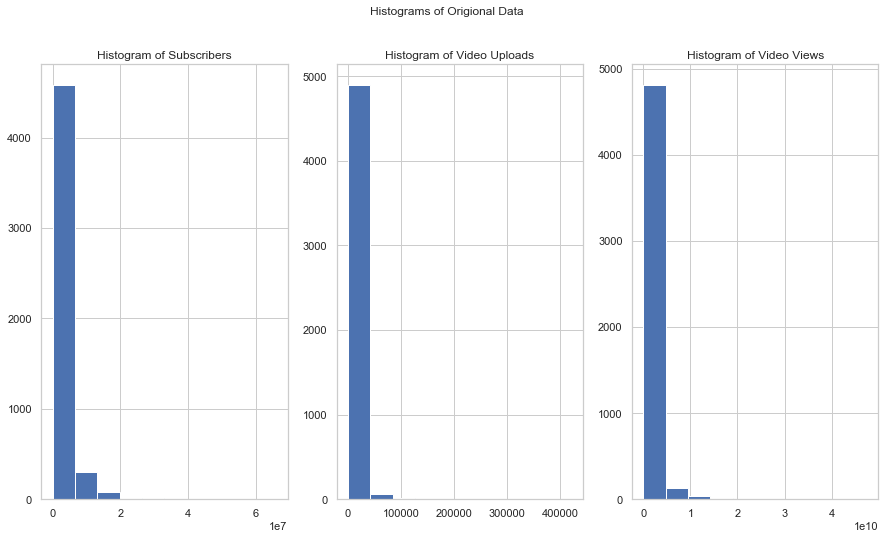

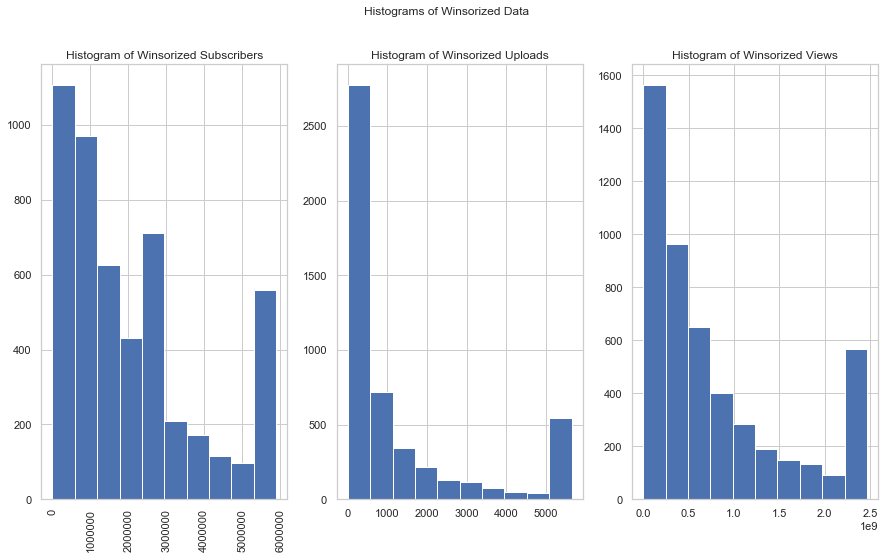

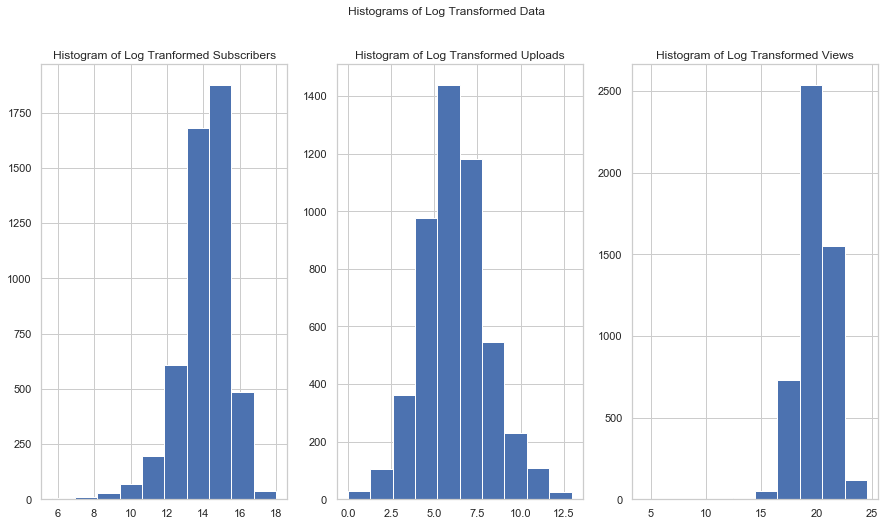

In [8]:
"""
    Many machine learning models assume the target variable to be normally distributed.  Non-normal variables can sometimes be transformed into normally distributed features using transformations such at taking the square root, the inverse, or the log of the variable; or by applying the Box-Cox transformation
"""
# histograms of the original data
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.hist(youtube_df["Subscribers"])
plt.title("Histogram of Subscribers")

plt.subplot(1,3,2)
plt.hist(youtube_df["Video Uploads"])
plt.title("Histogram of Video Uploads")

plt.subplot(1,3,3)
plt.hist(youtube_df["Video views"])
plt.title("Histogram of Video Views")

plt.suptitle("Histograms of Origional Data")

# Histograms of winsorized data
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.hist(youtube_df["winsorized_subscribers"])
plt.title("Histogram of Winsorized Subscribers")
plt.xticks(rotation=90)

plt.subplot(1,3,2)
plt.hist(youtube_df["winsorized_uploads"])
plt.title("Histogram of Winsorized Uploads")

plt.subplot(1,3,3)
plt.hist(youtube_df["winsorized_views"])
plt.title("Histogram of Winsorized Views")

plt.suptitle("Histograms of Winsorized Data")

# Histograms of Log transformed data
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.hist(np.log(youtube_df["Subscribers"]))
plt.title("Histogram of Log Tranformed Subscribers")

plt.subplot(1,3,2)
plt.hist(np.log(youtube_df["Video Uploads"]))
plt.title("Histogram of Log Transformed Uploads")

plt.subplot(1,3,3)
plt.hist(np.log(youtube_df["Video views"]))
plt.title("Histogram of Log Transformed Views")

plt.suptitle("Histograms of Log Transformed Data")

plt.show()

"""
    As illustrated below, taking the logs of the three variables transformed their distributions so that they more colosely resemble the normal distribution.  Though they are not exactly normally distributed.
""";

It appears that taking the logs of the three variables transformed the distributions of the  variables so that they more closely resemble the normal distribution.  However, they are not _exactly_ normally distributed.  In the example, you can statistically verify the distributions of the log transformed variables still don't follow the normal distribution using the **Jarque-Bera** and **Normal** tests from `scipy`:

In [9]:
"""
    You can statistically verify the distributions of the log transformed variables still don't follow the normal distribution by using the Jarque-Bera and Normal tests from scipy
"""
jb_stats = jarque_bera(np.log(youtube_df["Subscribers"]))
normal_stats = normaltest(np.log(youtube_df["Subscribers"]))

print("Stats for Subscribers:")
print(f"Jarque-Bera test statistic is {jb_stats[0]} and p-value is {jb_stats[1]}")
print(f"Normality test statistic is {normal_stats[0]} and p-value is {normal_stats[0]}")

jb_stats = jarque_bera(np.log(youtube_df["Video Uploads"]))
normal_stats = normaltest(np.log(youtube_df["Video Uploads"]))

print(f"\nStats for Video Uploads:")
print(f"Jarque-Bera test statistic is {jb_stats[0]} and p-value is {jb_stats[1]}")
print(f"Normality test statistic is {normal_stats[0]} and p-value is {normal_stats[0]}")

jb_stats = jarque_bera(np.log(youtube_df["Video views"]))
normal_stats = normaltest(np.log(youtube_df["Video views"]))

print(f"\nStats for Video Views:")
print(f"Jarque-Bera test statistic is {jb_stats[0]} and p-value is {jb_stats[1]}")
print(f"Normality test statistic is {normal_stats[0]} and p-value is {normal_stats[0]}")

Stats for Subscribers:
Jarque-Bera test statistic is 3650.185300455545 and p-value is 0.0
Normality test statistic is 1168.7793574548339 and p-value is 1168.7793574548339

Stats for Video Uploads:
Jarque-Bera test statistic is 83.01327886301631 and p-value is 0.0
Normality test statistic is 71.51141329001395 and p-value is 71.51141329001395

Stats for Video Views:
Jarque-Bera test statistic is 7862.3171340522895 and p-value is 0.0
Normality test statistic is 1180.823167194929 and p-value is 1180.823167194929


The p-values are 0 which indicates that the distribution of the log transformed variables is statistically different from the normal distribution.  However, these transformation might still be useful.  In general, working with distributions that "look" normal (with two tails on the left and right and a clustering of values around the mean) is easier than working with one tailed distributions.  That said, some models only require multivariate normality which can be achieved more easily using these kinds of distributions.  Hence, if you see that the distribution of a variable more closely resembles the normal distribution after a transformation, it could still be helpful even if it's not _exactly_ normal.

Another common method to make variables normally distributed is the **Box-Cox transformation**.  Applying this transformation is pretty easy using SciPy's `boxcox()` function from the `stats` module:

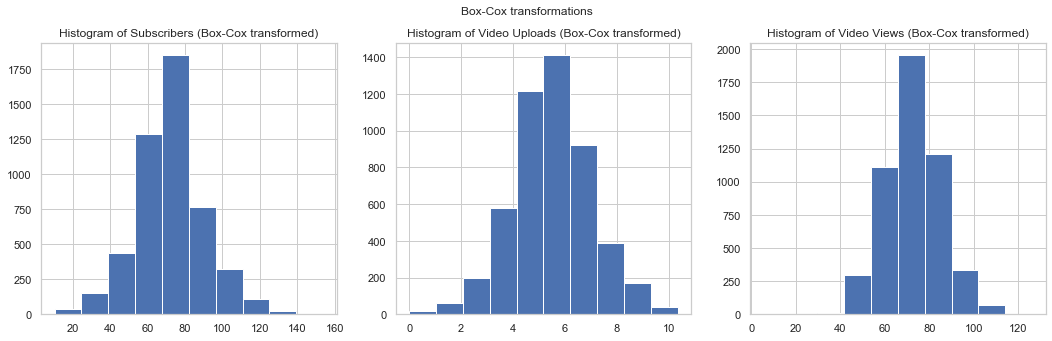

In [10]:
"""
    Another common method to make varibles normally distributed is the Box-Cox transformation.  This can be achieved using SciPy's boxcox() function.  Box-Cox, Log, and Square Root transformations only work when all datapoints are positive
"""
subscribers_boxcox,_ = boxcox(youtube_df["Subscribers"])
video_uploads_boxcox,_ = boxcox(youtube_df["Video Uploads"])
video_views_boxcox,_ = boxcox(youtube_df["Video views"])

plt.figure(figsize=(18,5))

# Histograms of the box-cox transformed data
plt.subplot(1,3,1)
plt.hist(subscribers_boxcox)
plt.title("Histogram of Subscribers (Box-Cox transformed)")

plt.subplot(1,3,2)
plt.hist(video_uploads_boxcox)
plt.title("Histogram of Video Uploads (Box-Cox transformed)")

plt.subplot(1,3,3)
plt.hist(video_views_boxcox)
plt.title("Histogram of Video Views (Box-Cox transformed)")

plt.suptitle("Box-Cox transformations")

plt.show();

The histograms above resemble the normal distribution quite well, although they are still not quite normally distributed.  You can confirm this using the Jarque-Bera and Normal tests.

In [11]:
jb_stats = jarque_bera(subscribers_boxcox)
normal_stats = normaltest(subscribers_boxcox)

print("Stats for Subscribers:")
print(f"Jarque-Bera test statistic is {jb_stats[0]} and p-value is {jb_stats[1]}")
print(f"Normality test statistic is {normal_stats[0]} and p-value is {normal_stats[0]}")

jb_stats = jarque_bera(video_uploads_boxcox)
normal_stats = normaltest(video_uploads_boxcox)

print(f"\nStats for Video Uploads:")
print(f"Jarque-Bera test statistic is {jb_stats[0]} and p-value is {jb_stats[1]}")
print(f"Normality test statistic is {normal_stats[0]} and p-value is {normal_stats[0]}")

jb_stats = jarque_bera(video_views_boxcox)
normal_stats = normaltest(video_views_boxcox)

print(f"\nStats for Video Views:")
print(f"Jarque-Bera test statistic is {jb_stats[0]} and p-value is {jb_stats[1]}")
print(f"Normality test statistic is {normal_stats[0]} and p-value is {normal_stats[0]}")

Stats for Subscribers:
Jarque-Bera test statistic is 112.2691040776772 and p-value is 0.0
Normality test statistic is 64.32778131642941 and p-value is 64.32778131642941

Stats for Video Uploads:
Jarque-Bera test statistic is 32.00644734618816 and p-value is 1.1217298223620276e-07
Normality test statistic is 23.237402615147847 and p-value is 23.237402615147847

Stats for Video Views:
Jarque-Bera test statistic is 93.4064021228951 and p-value is 0.0
Normality test statistic is 55.77146119242227 and p-value is 55.77146119242227


\* Note that Box-Cox, log, and square root transformation only work when all datapoints are positive.

### Normalization and Standardization

Some statistical techniques, such as Principal Components Analysis (PCA) - which is covered the next notebook 17.08: Feature Engineering 2: Dimensionality and PCA - and machine learning models assume that all features have values in the same range (e.g., a min of 0 and a max of 1) or they exhibit normal statistical properties.  For some techniques, features that vary in range can result in incorrect estimates and results.  To be able to apply these techniques and methods, you deed to rescale the variables to fit a limited range, or standardize the variables to exhibit some regular statistical patterns.

Two concepts of rescaling are covered in this notebook: **normalization** and **standardization**.
1. Normalization is the rescaling of a variable into the [0,1] range (including 0 and 1).  For this purpose, you'll use SKLearn's `normalize()` method from the `preprocessing` module.
2. Standardization is the rescaling of a variable so its mean becomes 0 and its standard deviation becomes 1.  Notice in the standardization you don't apply a maximum value for the variable.  To apply standardization, use SKLearn's `.scale()` method from the `preprocessing` module.

Now, see how you can normalize the winsorized versions of the continuous variables in the YouTube dataset:


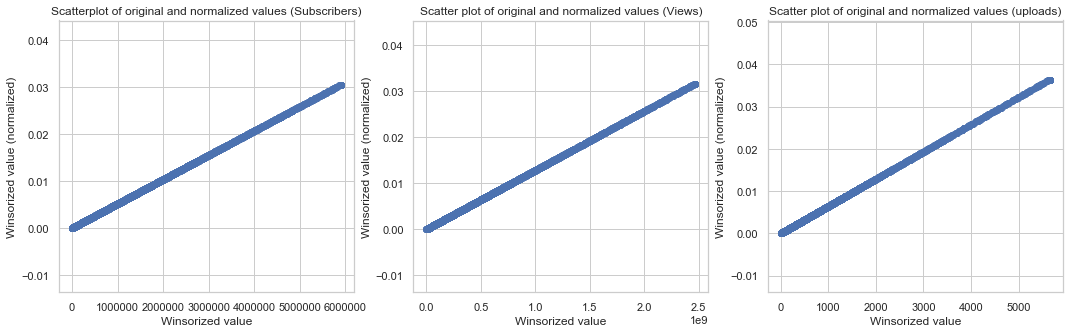

In [12]:
# Normalize the winsorized variables
youtube_df["norm_winsorized_subscribers"] = normalize(np.array(youtube_df["winsorized_subscribers"]).reshape(1,-1)).reshape(-1,1)
youtube_df["norm_winsorized_views"] = normalize(np.array(youtube_df["winsorized_views"]).reshape(1,-1)).reshape(-1,1)
youtube_df["norm_winsorized_uploads"] = normalize(np.array(youtube_df["winsorized_uploads"]).reshape(1,-1)).reshape(-1,1)

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.scatter(youtube_df["winsorized_subscribers"], youtube_df["norm_winsorized_subscribers"])
plt.title("Scatterplot of original and normalized values (Subscribers)")
plt.xlabel("Winsorized value")
plt.ylabel("Winsorized value (normalized)")

plt.subplot(1,3,2)
plt.scatter(youtube_df["winsorized_views"], youtube_df["norm_winsorized_views"])
plt.title("Scatter plot of original and normalized values (Views)")
plt.xlabel("Winsorized value")
plt.ylabel("Winsorized value (normalized)")

plt.subplot(1,3,3)
plt.scatter(youtube_df["winsorized_uploads"], youtube_df["norm_winsorized_uploads"])
plt.title("Scatter plot of original and normalized values (uploads)")
plt.xlabel("Winsorized value")
plt.ylabel("Winsorized value (normalized)")

plt.show();

This time, standardize the variables:

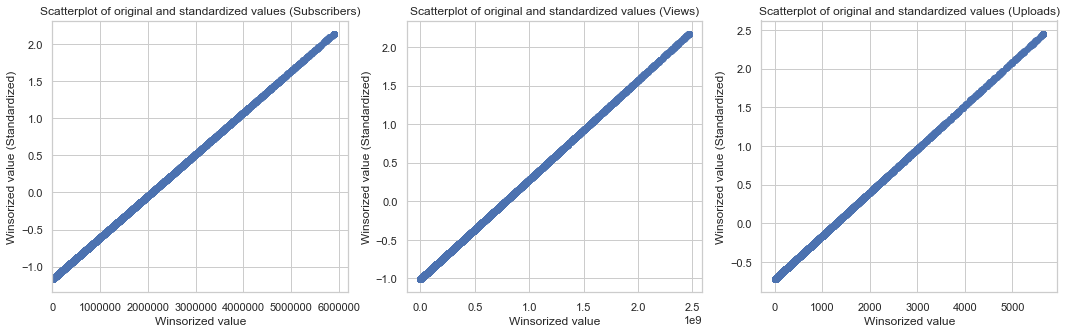

In [13]:
# This time Standardize the winsorized values
youtube_df["scaled_winsorized_subscribers"] = scale(youtube_df["winsorized_subscribers"])
youtube_df["scaled_winsorized_views"] = scale(youtube_df["winsorized_views"])
youtube_df["scaled_winsorized_uploads"] = scale(youtube_df["winsorized_uploads"])

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.scatter(youtube_df["winsorized_subscribers"], youtube_df["scaled_winsorized_subscribers"])
plt.title("Scatterplot of original and standardized values (Subscribers)")
plt.xlabel("Winsorized value")
plt.ylabel("Winsorized value (Standardized)")
plt.xlim(0.00000001)

plt.subplot(1,3,2)
plt.scatter(youtube_df["winsorized_views"], youtube_df["scaled_winsorized_views"])
plt.title("Scatterplot of original and standardized values (Views)")
plt.xlabel("Winsorized value")
plt.ylabel("Winsorized value (Standardized)")

plt.subplot(1,3,3)
plt.scatter(youtube_df["winsorized_uploads"], youtube_df["scaled_winsorized_uploads"])
plt.title("Scatterplot of original and standardized values (Uploads)")
plt.xlabel("Winsorized value")
plt.ylabel("Winsorized value (Standardized)")

plt.show();

## _Assignment_

In [178]:
kagle2 = dict(
    drivername="postgresql", 
    username="dsbc_student", 
    password="7*.8G9QH21", 
    host="142.93.121.174", 
    port="5432", 
    database="studentsperformance"
)

engine=create_engine(URL(**kagle2), echo=True)

student_df = pd.read_sql_query("SELECT * FROM studentsperformance", con=engine)

engine.dispose()

2019-11-25 21:22:41,929 INFO sqlalchemy.engine.base.Engine select version()
2019-11-25 21:22:41,943 INFO sqlalchemy.engine.base.Engine {}
2019-11-25 21:22:42,064 INFO sqlalchemy.engine.base.Engine select current_schema()
2019-11-25 21:22:42,067 INFO sqlalchemy.engine.base.Engine {}
2019-11-25 21:22:42,185 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-11-25 21:22:42,189 INFO sqlalchemy.engine.base.Engine {}
2019-11-25 21:22:42,245 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-11-25 21:22:42,249 INFO sqlalchemy.engine.base.Engine {}
2019-11-25 21:22:42,299 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2019-11-25 21:22:42,302 INFO sqlalchemy.engine.base.Engine {}
2019-11-25 21:22:42,428 INFO sqlalchemy.engine.base.Engine SELECT * FROM studentsperformance
2019-11-25 21:22:42,431 INFO sqlalchemy.engine.base.Engine {}


### _1. Are the exam score variables normally distributed? If not, apply a Box-Cox transformation. Does anything change?_

In [179]:
# Print a list of column headers 
print(*(x for x in student_df.columns), sep="\n")

gender
race/ethnicity
parental level of education
lunch
test preparation course
math score
reading score
writing score


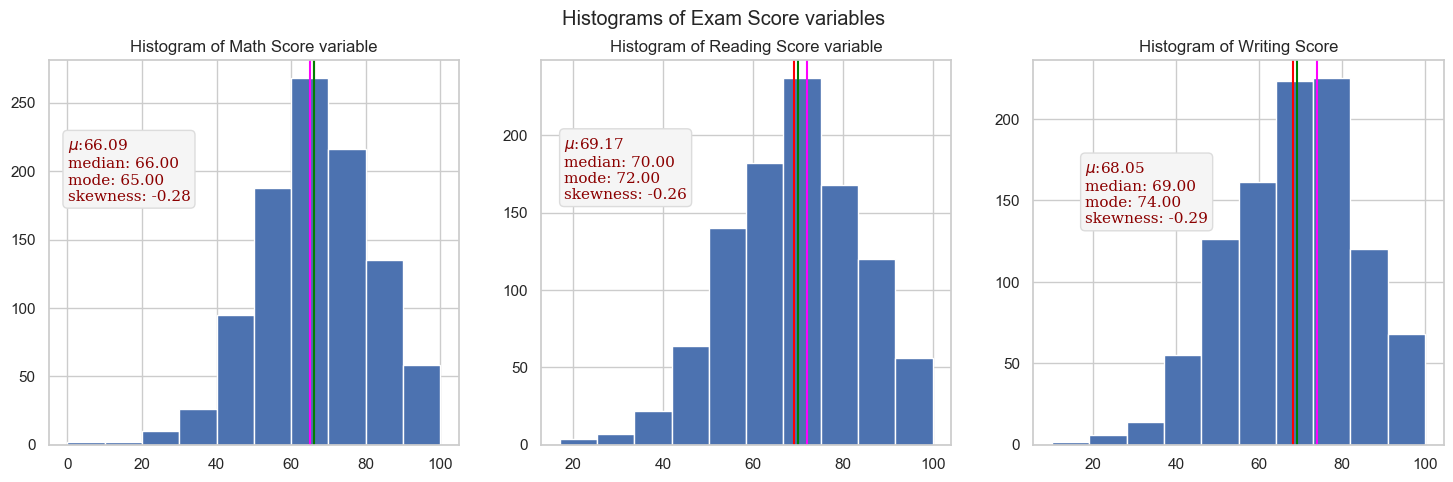

In [180]:
# Plot histograms to show distributions for the "math score", "reading score", and "writing score" variables
text_box = dict(boxstyle="round",ec="gainsboro",fc="whitesmoke")
font = dict(family="serif",color="darkred",weight="normal",size=11)

plt.figure(figsize=(18,5))

# Math Score variable
plt.subplot(1,3,1)
plt.hist(student_df["math score"]) 
plt.title("Histogram of Math Score variable")

math_mean = student_df["math score"].mean()
math_median = student_df["math score"].median()
math_mode = student_df["math score"].mode()
math_skew = student_df["math score"].skew()

plt.axvline(x=math_mean, color="red")
plt.axvline(x=math_median, color="green")
plt.axvline(x=math_mode[0], color="magenta")

textstr = f"$ \mu $:{math_mean:,.2f} \nmedian: {math_median:,.2f} \nmode: {math_mode[0]:,.2f} \nskewness: {math_skew:,.2f}"
plt.text(0.05,225,textstr,verticalalignment="top",fontdict=font,bbox=text_box)

# Reading Score variable
plt.subplot(1,3,2)
plt.hist(student_df["reading score"])
plt.title("Histogram of Reading Score variable")

reading_mean = student_df["reading score"].mean()
reading_median = student_df["reading score"].median()
reading_mode = student_df["reading score"].mode()
reading_skew = student_df["reading score"].skew()

plt.axvline(x=reading_mean, color="red")
plt.axvline(x=reading_median, color="green")
plt.axvline(x=reading_mode[0], color="magenta")

textstr = f"$ \mu $:{reading_mean:,.2f} \nmedian: {reading_median:,.2f} \nmode: {reading_mode[0]:,.2f} \nskewness: {reading_skew:,.2f}"
plt.text(18,200,textstr,verticalalignment="top",fontdict=font,bbox=text_box)

# Writing Score variable
plt.subplot(1,3,3)
plt.hist(student_df["writing score"])
plt.title("Histogram of Writing Score")

writing_mean = student_df["writing score"].mean()
writing_median = student_df["writing score"].median()
writing_mode = student_df["writing score"].mode()
writing_skew = student_df["writing score"].skew()

plt.axvline(x=writing_mean, color="red")
plt.axvline(x=writing_median, color="green")
plt.axvline(x=writing_mode[0], color="magenta")

textstr = f"$ \mu $:{writing_mean:,.2f} \nmedian: {writing_median:,.2f} \nmode: {writing_mode[0]:,.2f} \nskewness: {writing_skew:,.2f}"
plt.text(18,175,textstr,verticalalignment="top",fontdict=font,bbox=text_box)

plt.suptitle("Histograms of Exam Score variables")

plt.show();

The three exam score variables exhibit some skewness.  The Math Score is slightly negatively skewed at -0.28.  The Reading Score variable has a slight negative skew at -0.17.  Finally, the Writing Score variable has a slight negative skew at -0.19.

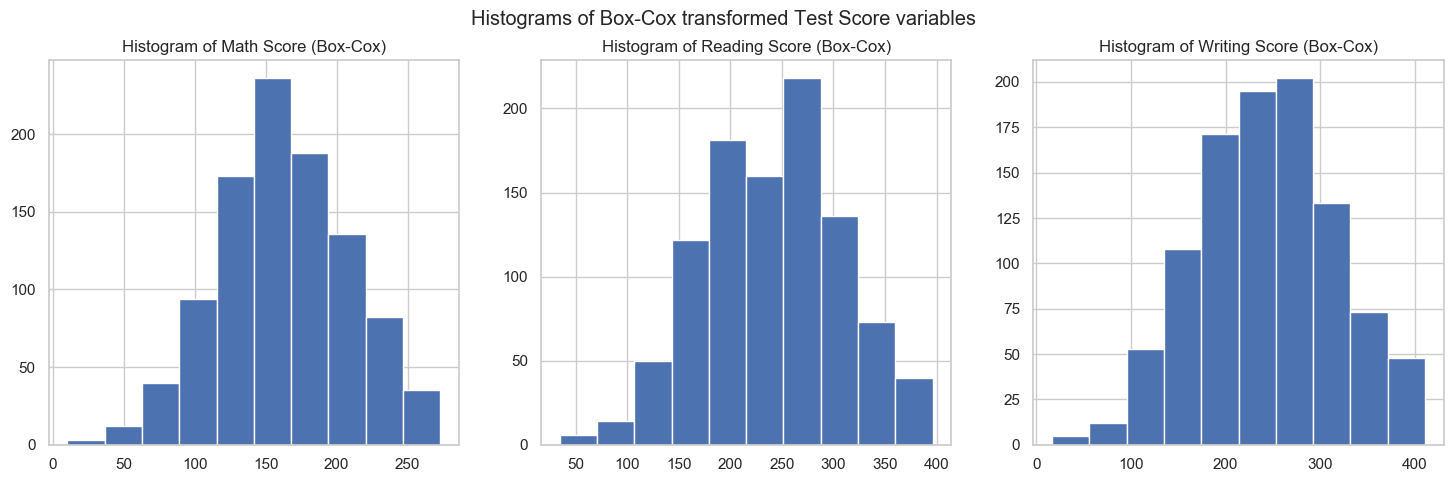

In [181]:
# Apply a Box-Cox transformation and compare
# The Box-Cox transformation will only work with positive numbers > 0.  There is an observation = 0, dropping
math_score_boxcox,_ = boxcox(student_df[student_df["math score"]>0]["math score"]) 
reading_score_boxcox,_ = boxcox(student_df["reading score"])
writing_score_boxcox,_ = boxcox(student_df["writing score"])

plt.figure(figsize=(18,5))

# Math Score Box-Cox
plt.subplot(1,3,1)
plt.hist(math_score_boxcox)
plt.title("Histogram of Math Score (Box-Cox)")

# Reading Score Box-Cox
plt.subplot(1,3,2)
plt.hist(reading_score_boxcox)
plt.title("Histogram of Reading Score (Box-Cox)")

# Writing Score Box-Cox
plt.subplot(1,3,3)
plt.hist(writing_score_boxcox)
plt.title("Histogram of Writing Score (Box-Cox)")

plt.suptitle("Histograms of Box-Cox transformed Test Score variables")

plt.show();

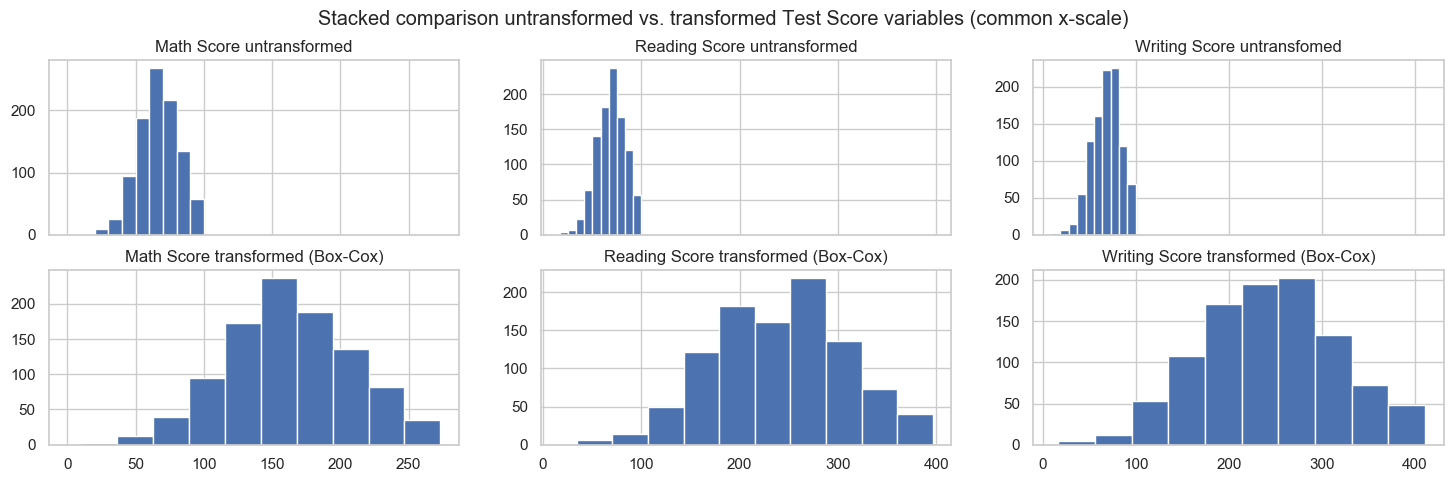

In [182]:
fig, axs = plt.subplots(2,3, figsize=(18,5), sharex="col", sharey=False)
# Math Score variable
axs[0,0].hist(student_df["math score"])
axs[0,0].set_title("Math Score untransformed")
axs[1,0].hist(math_score_boxcox)
axs[1,0].set_title("Math Score transformed (Box-Cox)")

# Reading Score variable
axs[0,1].hist(student_df["reading score"])
axs[0,1].set_title("Reading Score untransformed")
axs[1,1].hist(reading_score_boxcox)
axs[1,1].set_title("Reading Score transformed (Box-Cox)")

# Writig Score variable
axs[0,2].hist(student_df["writing score"])
axs[0,2].set_title("Writing Score untransfomed")
axs[1,2].hist(writing_score_boxcox)
axs[1,2].set_title("Writing Score transformed (Box-Cox)")

plt.suptitle("Stacked comparison untransformed vs. transformed Test Score variables (common x-scale)")

plt.show();

In [183]:
# Compare the distributions for the untransformed variables vs. the Box-Cox transformed variables
# Math Score variable
untransformed_jb_stats_math = jarque_bera(student_df["math score"])
untransformed_normal_math = normaltest(student_df["math score"])
untransformed_skew_math = student_df["math score"].skew()
transformed_jb_stats_math = jarque_bera(math_score_boxcox)
transformed_normal_math = normaltest(math_score_boxcox)
transformed_skew_math = skew(math_score_boxcox)

# Reading Score variable
untransformed_jb_stats_reading = jarque_bera(student_df["reading score"])
untransformed_normal_reading = normaltest(student_df["reading score"])
untransformed_skew_reading = student_df["reading score"].skew()
transformed_jb_stats_reading = jarque_bera(reading_score_boxcox)
transformed_normal_reading = normaltest(reading_score_boxcox)
transformed_skew_reading = skew(reading_score_boxcox)

# Writing Score variable
untransformed_jb_stats_writing = jarque_bera(student_df["writing score"])
untransformed_normal_writing = normaltest(student_df["writing score"])
untransformed_skew_writing = student_df["writing score"].skew()
transformed_jb_stats_writing = jarque_bera(writing_score_boxcox)
transformed_normal_writing = normaltest(writing_score_boxcox)
transformed_skew_writing = skew(writing_score_boxcox)

print("Stats for untransfomed Math Score variable:")
print(f"\t{'Jarque-Bera':<{14}}: {untransformed_jb_stats_math[0]:>{10},.6f} | "
    f"{'p-value'}: {untransformed_jb_stats_math[1]:>{10},.6f}")
print(f"\t{'Normality test':<{14}}: {untransformed_normal_math[0]:>{10},.6f} | "
    f"{'p-value'}: {untransformed_normal_math[1]:>{10},.6f}")
print(f"\t{'Skewness':<{14}}: {untransformed_skew_math:>{10},.6f}")
print(f"\t"+"-"*75)
print(f"\t{'Jarque-Bera':<{14}}: {transformed_jb_stats_math[0]:>{10},.6f} | "
    f"{'p-value'}: {transformed_jb_stats_math[1]:>{10},.6f}")
print(f"\t{'Normality test':<{14}}: {transformed_normal_math[0]:>{10},.6f} | "
    f"{'p-value'}: {transformed_normal_math[1]:>{10},.6f}")
print(f"\t{'Skewness':<{14}}: {transformed_skew_math:>{10},.6f}")

print("\nStats for untransfomed Reading Score variable:")
print(f"\t{'Jarque-Bera':<{14}}: {untransformed_jb_stats_reading[0]:>{10},.6f} | "
    f"{'p-value'}: {untransformed_jb_stats_reading[1]:>{10},.6f}")
print(f"\t{'Normality test':<{14}}: {untransformed_normal_reading[0]:>{10},.6f} | "
    f"{'p-value'}: {untransformed_normal_reading[1]:>{10},.6f}")
print(f"\t{'Skewness':<{14}}: {untransformed_skew_reading:>{10},.6f}")
print(f"\t"+"-"*75)
print(f"\t{'Jarque-Bera':<{14}}: {transformed_jb_stats_reading[0]:>{10},.6f} | "
    f"{'p-value'}: {transformed_jb_stats_reading[1]:>{10},.6f}")
print(f"\t{'Normality test':<{14}}: {transformed_normal_reading[0]:>{10},.6f} | "
    f"{'p-value'}: {transformed_normal_reading[1]:>{10},.6f}")
print(f"\t{'Skewness':<{14}}: {transformed_skew_reading:>{10},.6f}")

print("\nStats for untransfomed Writing Score variable:")
print(f"\t{'Jarque-Bera':<{14}}: {untransformed_jb_stats_writing[0]:>{10},.6f} | "
    f"{'p-value'}: {untransformed_jb_stats_writing[1]:>{10},.6f}")
print(f"\t{'Normality test':<{14}}: {untransformed_normal_writing[0]:>{10},.6f} | "
    f"{'p-value'}: {untransformed_normal_writing[1]:>{10},.6f}")
print(f"\t{'Skewness':<{14}}: {untransformed_skew_writing:>{10},.6f}")
print(f"\t"+"-"*75)
print(f"\t{'Jarque-Bera':<{14}}: {transformed_jb_stats_writing[0]:>{10},.6f} | "
    f"{'p-value'}: {transformed_jb_stats_writing[1]:>{10},.6f}")
print(f"\t{'Normality test':<{14}}: {transformed_normal_writing[0]:>{10},.6f} | "
    f"{'p-value'}: {transformed_normal_writing[1]:>{10},.6f}")
print(f"\t{'Skewness':<{14}}: {transformed_skew_writing:>{10},.6f}")

Stats for untransfomed Math Score variable:
	Jarque-Bera   :  15.912257 | p-value:   0.000351
	Normality test:  15.408961 | p-value:   0.000451
	Skewness      :  -0.278935
	---------------------------------------------------------------------------
	Jarque-Bera   :   1.720098 | p-value:   0.423141
	Normality test:   1.832308 | p-value:   0.400055
	Skewness      :  -0.018496

Stats for untransfomed Reading Score variable:
	Jarque-Bera   :  11.383301 | p-value:   0.003374
	Normality test:  11.117413 | p-value:   0.003854
	Skewness      :  -0.259105
	---------------------------------------------------------------------------
	Jarque-Bera   :   4.119779 | p-value:   0.127468
	Normality test:   5.282275 | p-value:   0.071280
	Skewness      :  -0.031815

Stats for untransfomed Writing Score variable:
	Jarque-Bera   :  13.985094 | p-value:   0.000919
	Normality test:  13.606451 | p-value:   0.001110
	Skewness      :  -0.289444
	-----------------------------------------------------------------

### _2. Say we want to use a single variable for the exam scores as our target. For this purpose, create a new variable by taking a weighted average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether or not the transformed variable is normally distributed._

In [184]:
# Question disambiguation: Cannot create a weighted average as there are no weights
student_df["avg_score"] = (student_df["math score"] + student_df["reading score"] + student_df["writing score"])/3

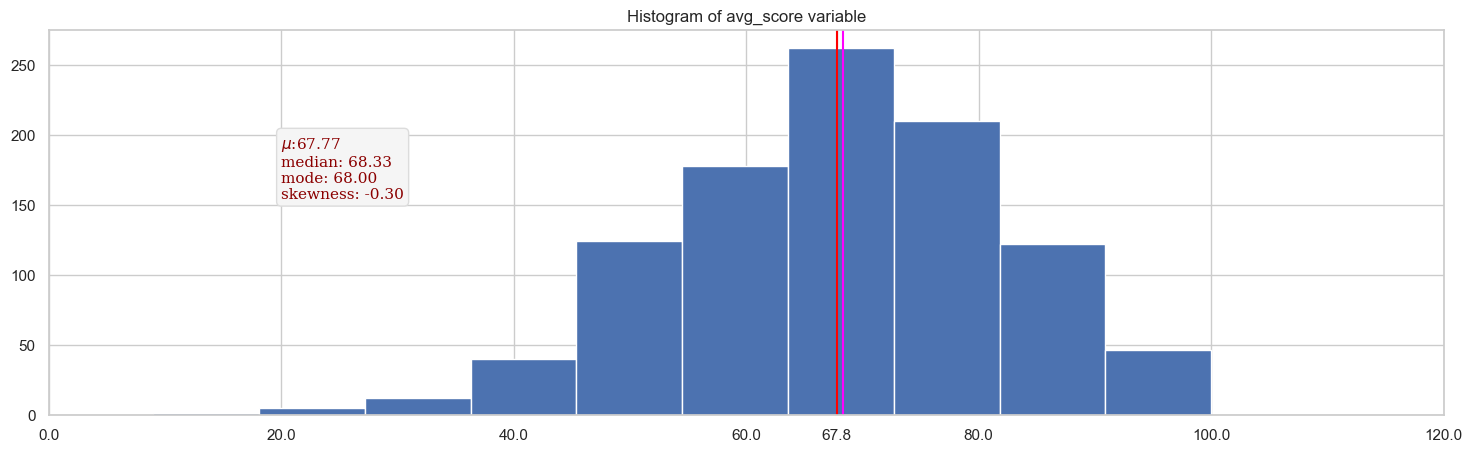

In [185]:
# Take a look at the distribution of the avg_score variable
plt.figure(figsize=(18,5))

plt.hist(student_df["avg_score"])
plt.title("Histogram of avg_score variable")

avg_score_mean = student_df["avg_score"].mean()
avg_score_median = student_df["avg_score"].median()
avg_score_mode = student_df["avg_score"].mode()
avg_score_skew = student_df["avg_score"].skew()

plt.axvline(x=avg_score_mean, color="red")
plt.axvline(x=avg_score_median, color="magenta")

extraticks = [avg_score_mean]
plt.xticks(list(plt.xticks()[0])+extraticks)

textstr = f"$ \mu $:{avg_score_mean:,.2f} \nmedian: {avg_score_median:,.2f} \nmode: {avg_score_mode[0]:,.2f} \nskewness: {avg_score_skew:,.2f}"
plt.text(20,200,textstr,verticalalignment="top",fontdict=font,bbox=text_box)

plt.show();

In [186]:
untransformed_jb_stats_avg_score = jarque_bera(student_df["avg_score"])
untransformed_normal_avg_score = normaltest(student_df["avg_score"])
untransformed_skew_avg_score = student_df["avg_score"].skew()

print("Stats for untransfomed Math Score variable:")
print(f"\t{'Jarque-Bera':<{14}}: {untransformed_jb_stats_avg_score[0]:>{10},.6f} | "
    f"{'p-value'}: {untransformed_jb_stats_avg_score[1]:>{10},.6f}")
print(f"\t{'Normality test':<{14}}: {untransformed_normal_avg_score[0]:>{10},.6f} | "
    f"{'p-value'}: {untransformed_normal_avg_score[1]:>{10},.6f}")
print(f"\t{'Skewness':<{14}}: {untransformed_skew_avg_score:>{10},.6f}")

Stats for untransfomed Math Score variable:
	Jarque-Bera   :  15.453388 | p-value:   0.000441
	Normality test:  15.186721 | p-value:   0.000504
	Skewness      :  -0.299057


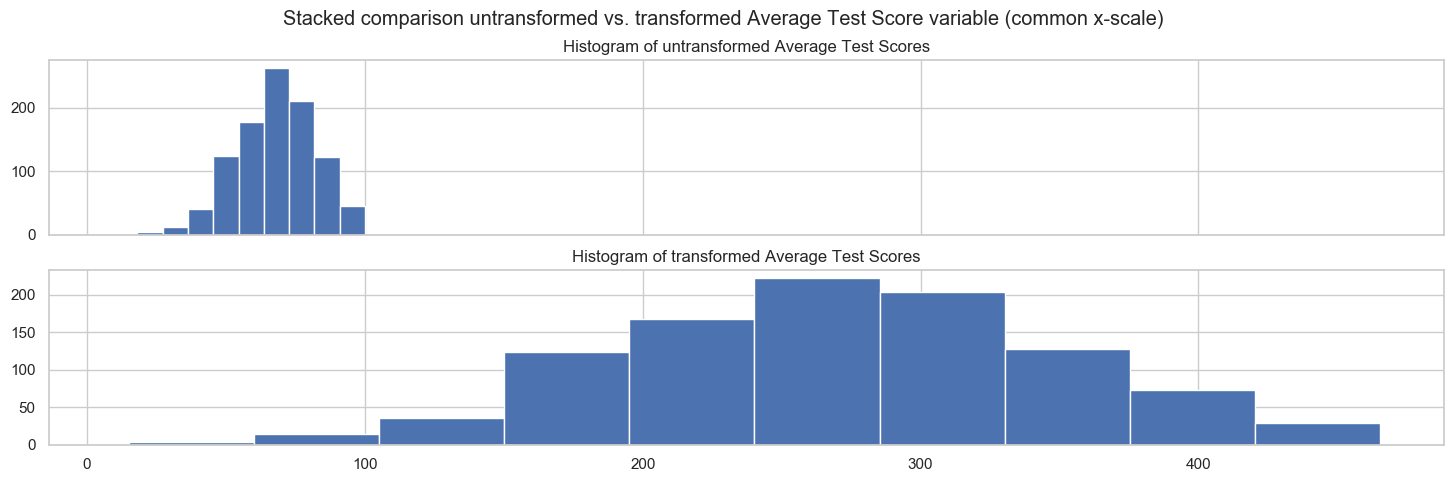

In [187]:
# Apply a Box-Cox Transformation to the avg_score varialbe
avg_score_boxcox,_ = boxcox(student_df["avg_score"]) 

fig, axs = plt.subplots(2,1, figsize=(18,5), sharex="col", sharey=False)

axs[0].hist(student_df["avg_score"])
axs[0].set_title("Histogram of untransformed Average Test Scores")

axs[1].hist(avg_score_boxcox)
axs[1].set_title("Histogram of transformed Average Test Scores")

plt.suptitle("Stacked comparison untransformed vs. transformed Average Test Score variable (common x-scale)")

plt.show();

In [188]:
transformed_jb_stats_avg = jarque_bera(avg_score_boxcox)
transformed_normal_avg = normaltest(avg_score_boxcox)
transformed_skew_avg = skew(avg_score_boxcox)

print("Stats for transfomed Average Score variable:")
print(f"\t{'Jarque-Bera':<{14}}: {transformed_jb_stats_avg[0]:>{10},.6f} | "
    f"{'p-value'}: {transformed_jb_stats_avg[1]:>{10},.6f}")
print(f"\t{'Normality test':<{14}}: {transformed_normal_avg[0]:>{10},.6f} | "
    f"{'p-value'}: {transformed_normal_avg[1]:>{10},.6f}")
print(f"\t{'Skewness':<{14}}: {transformed_skew_avg:>{10},.6f}")

Stats for transfomed Average Score variable:
	Jarque-Bera   :   2.435399 | p-value:   0.295910
	Normality test:   2.779858 | p-value:   0.249093
	Skewness      :  -0.023945


### _3. Which variables seem related to the target variable (the newly created variable in the previous question)? If our goal is to explain the determinants of success in exams, which variables in our dataset might be useful?_

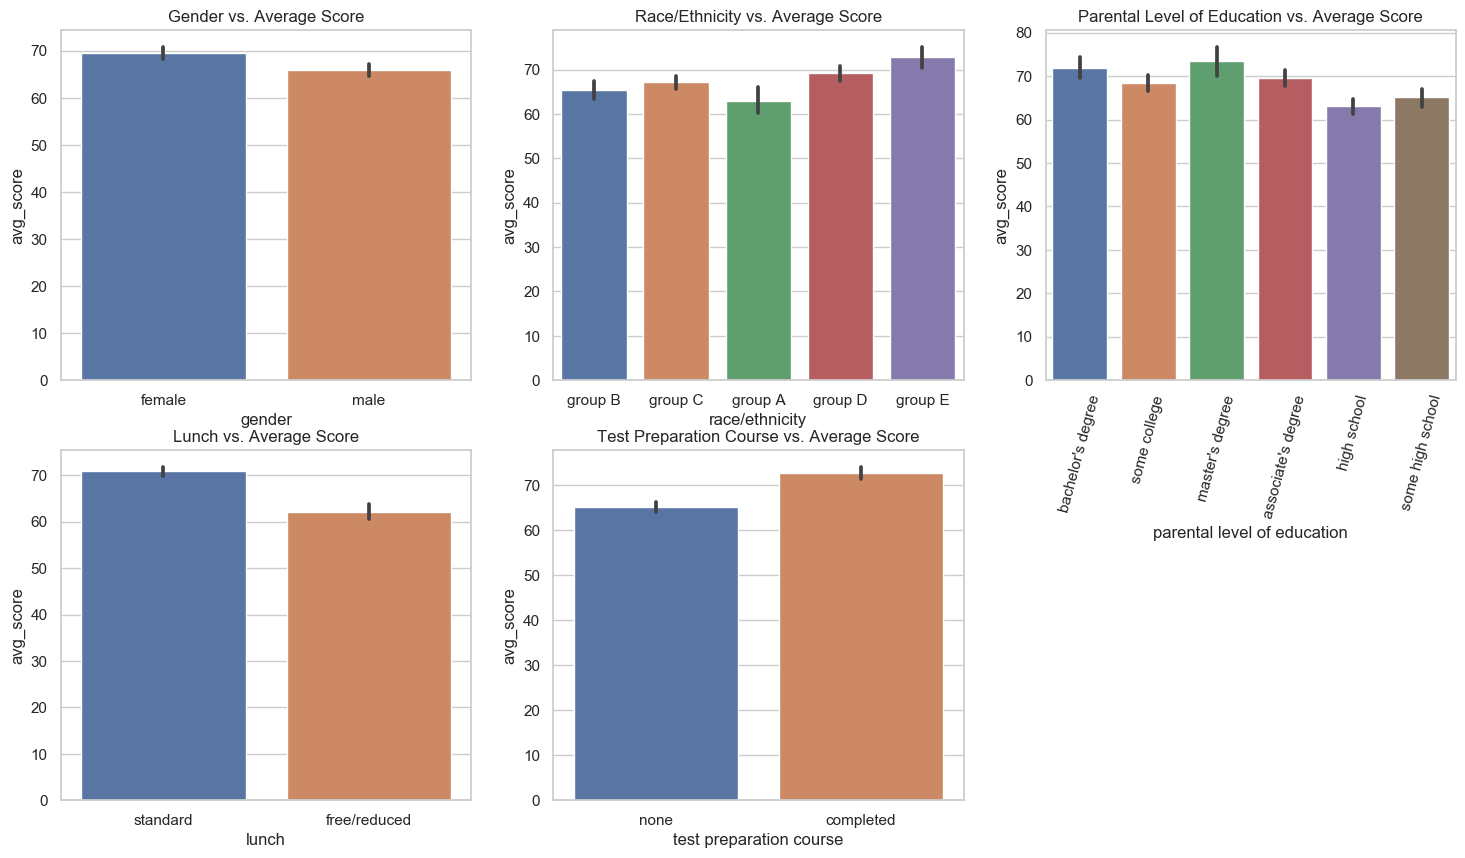

In [189]:
plt.figure(figsize=(18,10))

plt.subplot(2,3,1)
sns.barplot(student_df["gender"], student_df["avg_score"])
plt.title("Gender vs. Average Score")

plt.subplot(2,3,2)
sns.barplot(student_df["race/ethnicity"], student_df["avg_score"])
plt.title("Race/Ethnicity vs. Average Score")

plt.subplot(2,3,3)
sns.barplot(student_df["parental level of education"], student_df["avg_score"])
plt.title("Parental Level of Education vs. Average Score")
plt.xticks(rotation=75)

plt.subplot(2,3,4)
sns.barplot(student_df["lunch"], student_df["avg_score"])
plt.title("Lunch vs. Average Score")

plt.subplot(2,3,5)
sns.barplot(student_df["test preparation course"], student_df["avg_score"])
plt.title("Test Preparation Course vs. Average Score")

plt.show();

In [207]:
"""
    This is a bivariate analysis of five categorical values: gender, race/ethnicity, parental level of education, lunch, and test preparation course vs. the avg_score derrived variable
"""
# Function to perform a bivariate analysis of categorical data
def run_bivariate_test(criteria, data_frame, data_cols):
    cats = data_frame[criteria].unique()
    cat_df = data_frame.groupby(criteria)

    for col in data_cols:
        print("-"*(len(max(data_cols, key=len))+100))
        print(f"Comparisons for variable {col}")
        for i in range(0,len(cats)):
            for j in range(i+1,len(cats)):
                print(f"\t t-test between groups {cats[i]} and {cats[j]}:", end=" ")
                print(stats.ttest_ind(
                    data_frame[data_frame[criteria]==cats[i]][col], 
                    data_frame[data_frame[criteria]==cats[j]][col]
                ))
                print(" "*(len(max(data_cols, key=len))+100))
        print("="*(len(max(data_cols, key=len))+100))

In [208]:
# Perform the Bivariate analysis on the categorical columns vs. the target variable
run_bivariate_test("gender", student_df, ["avg_score"])
run_bivariate_test("race/ethnicity", student_df, ["avg_score"])
run_bivariate_test("parental level of education", student_df, ["avg_score"])
run_bivariate_test("lunch", student_df, ["avg_score"])
run_bivariate_test("test preparation course", student_df, ["avg_score"])

-------------------------------------------------------------------------------------------------------------
Comparisons for variable avg_score
	 t-test between groups female and male: Ttest_indResult(statistic=4.169913529142, pvalue=3.311973638243664e-05)
                                                                                                             
-------------------------------------------------------------------------------------------------------------
Comparisons for variable avg_score
	 t-test between groups group B and group C: Ttest_indResult(statistic=-1.2782467415831538, pvalue=0.20174731227733955)
                                                                                                             
	 t-test between groups group B and group A: Ttest_indResult(statistic=1.3165043669633527, pvalue=0.1890930589509443)
                                                                                                             
	 t-test between groups group

#### _Hypothesis testing:_
Null Hypothesis: $ H_o: \mu_f = \mu_s $ <br />
Hypothesis: $ H_a: \mu_f \neq \mu_s $ <br />
$ \alpha = 0.05 $ <br />

A p-value < the signifigance level ($ \alpha = 0.05 $) $ \therefore $ you can reject the null hypothesis which suggests the alternative.  A p-value > $ \alpha \therefore $ you fail to reject the null hypothesis  and would not have suficient evidence to conclude the alternative.

All of the categorical values have a p-value > $ \alpha $ suggesting that there is not a direct relationship between the category and average test score.